<a href="https://colab.research.google.com/github/Ishita05Goel/StockMarketPredictionModel/blob/main/StockMarketPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/60


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


222/222 - 18s - 80ms/step - loss: 1.7756e-05 - mae: 0.0024 - val_loss: 8.9290e-05 - val_mae: 0.0080
Epoch 2/60
222/222 - 15s - 67ms/step - loss: 4.9162e-06 - mae: 0.0015 - val_loss: 3.5057e-04 - val_mae: 0.0154
Epoch 3/60
222/222 - 18s - 81ms/step - loss: 4.7817e-06 - mae: 0.0014 - val_loss: 6.6152e-04 - val_mae: 0.0219
Epoch 4/60
222/222 - 17s - 78ms/step - loss: 4.0019e-06 - mae: 0.0013 - val_loss: 3.4425e-04 - val_mae: 0.0152
Epoch 5/60
222/222 - 15s - 69ms/step - loss: 3.9789e-06 - mae: 0.0014 - val_loss: 2.9789e-04 - val_mae: 0.0139
Epoch 6/60
222/222 - 20s - 90ms/step - loss: 3.7447e-06 - mae: 0.0013 - val_loss: 1.3419e-04 - val_mae: 0.0086
Epoch 7/60
222/222 - 21s - 93ms/step - loss: 3.6067e-06 - mae: 0.0013 - val_loss: 4.7210e-05 - val_mae: 0.0048
Epoch 8/60
222/222 - 20s - 92ms/step - loss: 3.1799e-06 - mae: 0.0012 - val_loss: 3.1785e-04 - val_mae: 0.0143
Epoch 9/60
222/222 - 15s - 68ms/step - loss: 3.2696e-06 - mae: 0.0012 - val_loss: 1.4942e-04 - val_mae: 0.0089
Epoch 10/60


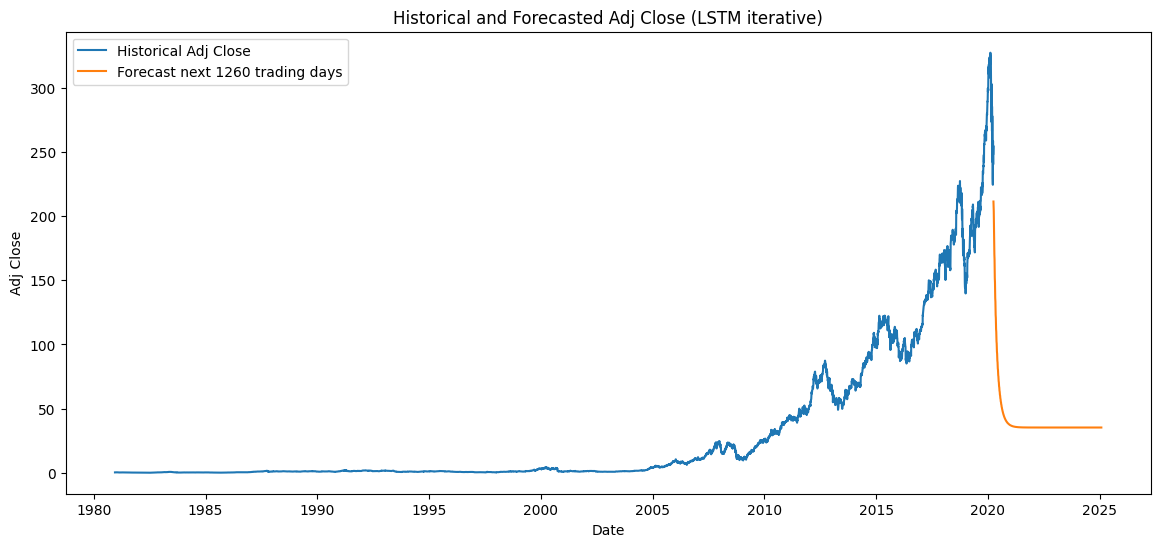

Forecast saved to adj_close_5yr_forecast.csv


In [ ]:
# LSTM multi-step forecasting (iterative) — run in your environment (Colab / local)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import datetime

# ---------- Config ----------
FILE = "/content/AAPL.csv"  # your uploaded file
TARGET_COL = "Adj Close"   # use Adjusted Close
LOOKBACK = 60              # days used to predict next day
TEST_SIZE = 0.2            # final portion reserved as test (time-ordered)
EPOCHS = 60
BATCH_SIZE = 32
FUTURE_DAYS = 252 * 5     # ~5 years of trading days (approx)
# ----------------------------

# Load and prepare
df = pd.read_csv(FILE, parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df = df.dropna(subset=[TARGET_COL])

# Optionally use additional features:
features = ['Adj Close', 'Volume']  # you can add 'Open','High','Low' if you like
data = df[features].copy()

# Scale features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Helper: create sequences
def create_sequences(X, lookback=60):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(X[i, 0])   # target is column 0 (Adj Close) after scaling
    return np.array(Xs), np.array(ys)

X_all, y_all = create_sequences(data_scaled, LOOKBACK)

# Train/test split (time-ordered)
split_idx = int((1 - TEST_SIZE) * len(X_all))
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]

# Build LSTM
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=[es],
    verbose=2
)

# Evaluate on test set (one-step)
y_pred_test = model.predict(X_test).flatten()
# inverse scale for meaningful metrics
# create array shaped (n, n_features) to invert scaler (we only know first col predicted)
def inverse_adjclose(scaler, scaled_adj_arr):
    # scaled_adj_arr: shape (n,)
    dummy = np.zeros((len(scaled_adj_arr), data.shape[1]))
    dummy[:,0] = scaled_adj_arr
    inv = scaler.inverse_transform(dummy)
    return inv[:,0]

y_test_inv = inverse_adjclose(scaler, y_test)
y_pred_test_inv = inverse_adjclose(scaler, y_pred_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test_inv, y_pred_test_inv)
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# -------------------------
# Iterative forecasting for FUTURE_DAYS
# -------------------------
# Start from the very last LOOKBACK window in the dataset
last_window = data_scaled[-LOOKBACK:].copy()  # shape (LOOKBACK, n_features)
future_preds_scaled = []

current_window = last_window.copy()
for i in range(FUTURE_DAYS):
    # model expects shape (1, LOOKBACK, n_features)
    pred_scaled = model.predict(current_window.reshape(1, LOOKBACK, data.shape[1]))[0,0]
    future_preds_scaled.append(pred_scaled)
    # append predicted row to current_window: we need to supply all features;
    # for non-price features (Volume) we can keep last observed volume or set to 0.
    # Here we append a row where Adj Close = pred_scaled and Volume = last known scaled volume.
    next_row = np.zeros((data.shape[1],))
    next_row[0] = pred_scaled
    next_row[1:] = current_window[-1,1:]  # keep last known values for other features
    current_window = np.vstack([current_window[1:], next_row])

# Inverse transform predictions
future_preds = inverse_adjclose(scaler, np.array(future_preds_scaled))

# Build future dates (business days)
last_date = df['Date'].max()
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=FUTURE_DAYS)

# Put into DataFrame
future_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Adj_Close": future_preds
})

# Plot historical Adj Close + forecast
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Adj Close'], label='Historical Adj Close')
plt.plot(future_df['Date'], future_df['Predicted_Adj_Close'], label=f'Forecast next {FUTURE_DAYS} trading days')
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.legend()
plt.title("Historical and Forecasted Adj Close (LSTM iterative)")
plt.show()

# Save forecast to CSV
future_df.to_csv("adj_close_5yr_forecast.csv", index=False)
print("Forecast saved to adj_close_5yr_forecast.csv")
